In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # pip install seaborn
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.svm import SVC
import warnings

# Housekeeping
warnings.filterwarnings("ignore")

In [175]:
features = np.load("face_images.npz")
features = features.get(features.files[0])  # images
features = np.moveaxis(features, -1, 0)
features = features.reshape(features.shape[0], features.shape[1], features.shape[1], 1)

In [176]:
# % load the dataset
face_images_db = np.load("face_images.npz")["face_images"]
facial_keypoints_df = pd.read_csv("facial_keypoints.csv")


numMissingKeypoints = facial_keypoints_df.isnull().sum(axis=1)
allKeypointsPresentInds = np.nonzero(numMissingKeypoints == 0)[0]

faceImagesDB = face_images_db[:, :, allKeypointsPresentInds]
facialKeypointsDF = facial_keypoints_df.iloc[allKeypointsPresentInds, :].reset_index(
    drop=True
)

(imHeight, imWidth, numImages) = faceImagesDB.shape
numKeypoints = facialKeypointsDF.shape[1] / 2

print("number of remaining images = %d" % (numImages))
print("image dimentions = (%d,%d)" % (imHeight, imWidth))
print("number of facial keypoints = %d" % (numKeypoints))

number of remaining images = 2140
image dimentions = (96,96)
number of facial keypoints = 15


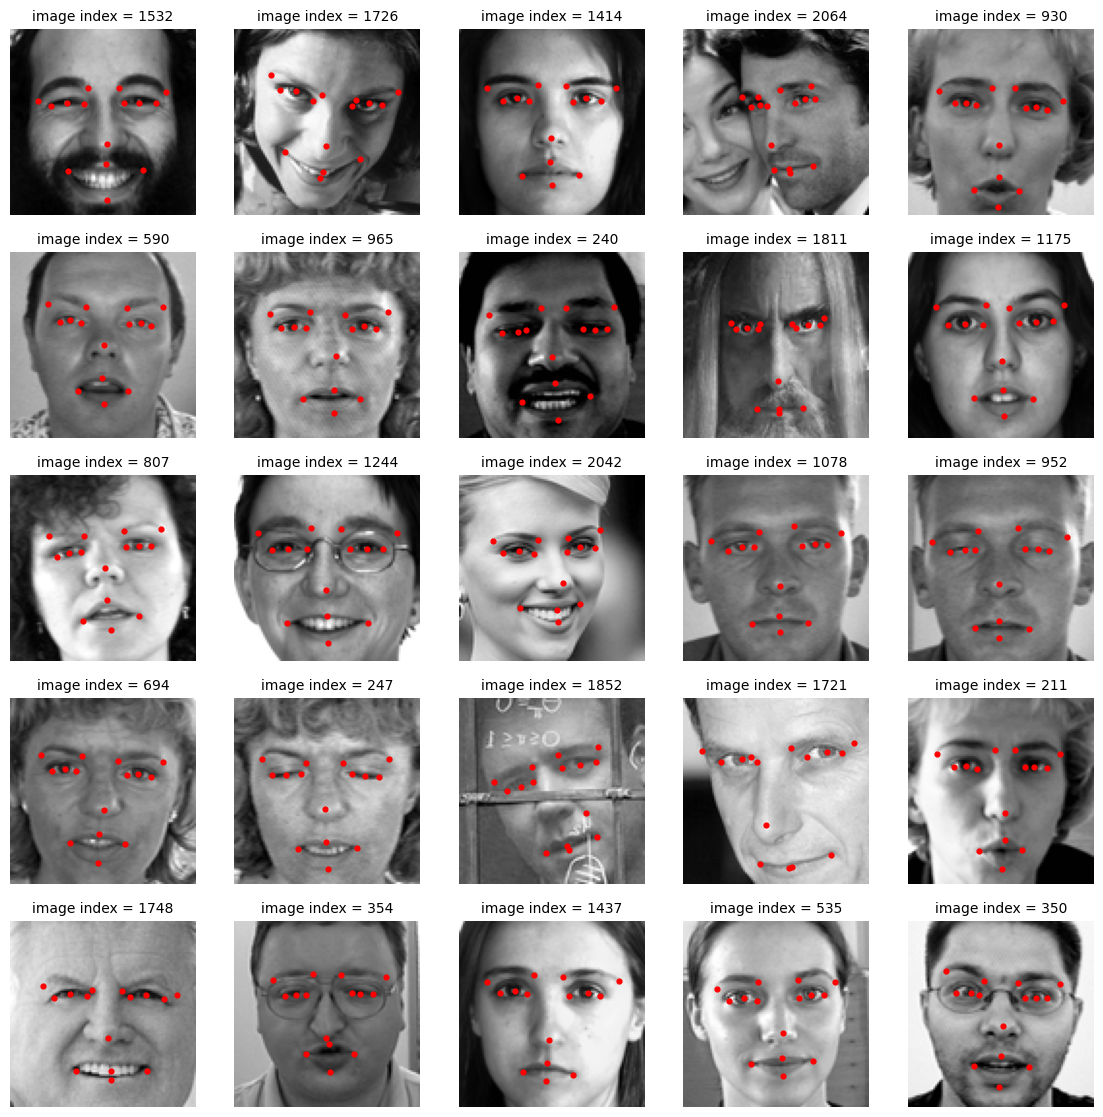

In [177]:
# show a random subset of images from the dataset
num_fig_rows = 5
num_fig_cols = 5

num_plots = num_fig_rows * num_fig_cols

np.random.seed(42)
rand_inds_vec = np.random.choice(faceImagesDB.shape[2], num_plots, replace=False)
rand_inds_mat = rand_inds_vec.reshape((num_fig_rows, num_fig_cols))

plt.close("all")
fig, ax = plt.subplots(nrows=num_fig_rows, ncols=num_fig_cols, figsize=(14, 14))

for i in range(num_fig_rows):
    for j in range(num_fig_cols):
        curr_ind = rand_inds_mat[i][j]
        curr_image = faceImagesDB[:, :, curr_ind]

        x_feature_coords = np.array(facialKeypointsDF.iloc[curr_ind, 0:30:2].tolist())
        y_feature_coords = np.array(facialKeypointsDF.iloc[curr_ind, 1:30:2].tolist())

        ax[i][j].imshow(curr_image, cmap="gray")
        ax[i][j].scatter(x_feature_coords, y_feature_coords, c="r", s=12)
        ax[i][j].set_axis_off()
        ax[i][j].set_title("image index = %d" % (curr_ind), fontsize=10)

In [178]:
facial_keypoints_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [217]:
# Separates the facial keypoints by x and y
x_feature_coords = np.array(facialKeypointsDF.iloc[:, 0:30:2])
y_feature_coords = np.array(facialKeypointsDF.iloc[:, 1:30:2])

num_components = 15
nmf = NMF(n_components=num_components)

# Applies NMF to both x and y
facialKeypointsDF_NMF_X = pd.DataFrame(data=nmf.fit_transform(x_feature_coords))
facialKeypointsDF_NMF_Y = pd.DataFrame(data=nmf.fit_transform(y_feature_coords))

# Scale back the reduced components to the original scale
scaling_factor = (
    96 / 2
)  # Adjust this factor based on how much you scaled the coordinates
scaled_x_feature_coords = facialKeypointsDF_NMF_X * scaling_factor
scaled_y_feature_coords = facialKeypointsDF_NMF_Y * scaling_factor

# Convert the scaled coordinates back to DataFrame format if needed
facialKeypointsDF_scaled_X = pd.DataFrame(data=scaled_x_feature_coords)
facialKeypointsDF_scaled_Y = pd.DataFrame(data=scaled_y_feature_coords)

In [206]:
print(x_feature_coords[0])

[66.03356391 30.22700752 59.58207519 73.13034586 36.35657143 23.45287218
 56.95326316 80.22712782 40.22760902 16.35637895 44.42057143 61.19530827
 28.61449624 43.3126015  43.13070677]


In [207]:
facialKeypointsDF_scaled_X.head(1)

,0,1
0,0.0,141.014108


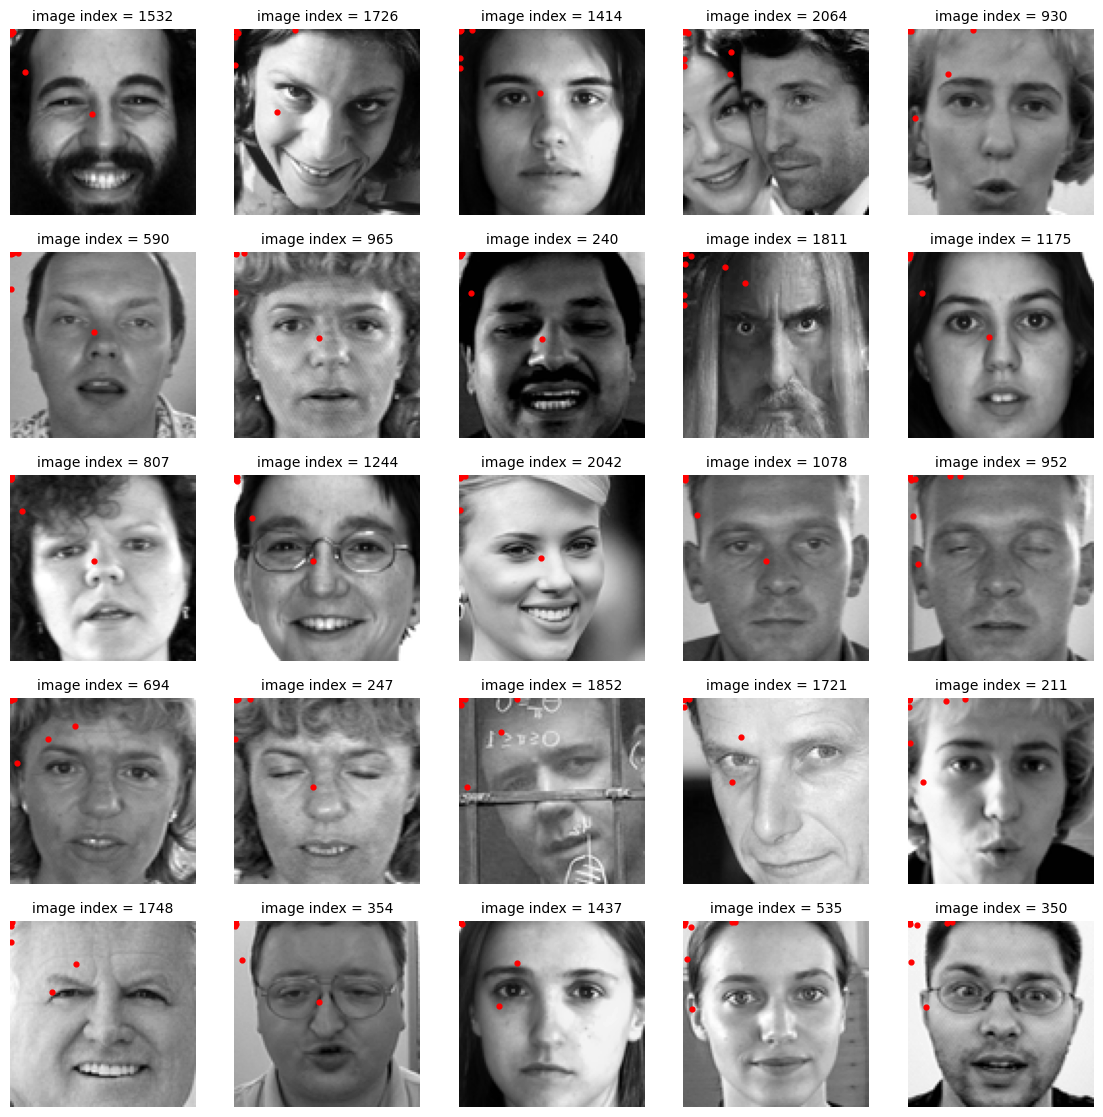

In [218]:
# show a random subset of images from the dataset
np.random.seed(42)
rand_inds_vec = np.random.choice(faceImagesDB.shape[2], num_plots, replace=False)
rand_inds_mat = rand_inds_vec.reshape((num_fig_rows, num_fig_cols))

plt.close("all")
fig, ax = plt.subplots(nrows=num_fig_rows, ncols=num_fig_cols, figsize=(14, 14))

for i in range(num_fig_rows):
    for j in range(num_fig_cols):
        curr_ind = rand_inds_mat[i][j]
        curr_image = faceImagesDB[:, :, curr_ind]

        x_feature_coords = np.array(
            facialKeypointsDF_scaled_X.iloc[curr_ind, 0:num_components].tolist()
        )
        y_feature_coords = np.array(
            facialKeypointsDF_scaled_Y.iloc[curr_ind, 0:num_components].tolist()
        )

        ax[i][j].imshow(curr_image, cmap="gray")
        ax[i][j].scatter(x_feature_coords, y_feature_coords, c="r", s=12)
        ax[i][j].set_axis_off()
        ax[i][j].set_title("image index = %d" % (curr_ind), fontsize=10)